## Classification White Colonies (WC) VS Red Colonies (RC)

### Data preprocessing

Data preprocessing steps:
* unzip data
* combine two images (light and dark) into one by `np.maximum` operation
* extract patches according to information from `.csv` files
* remove from dataset patches with width or height less than `100` pixels (images behaves differently)
* convert dataset to ImageNet form

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
from PIL import Image
from dataset_preprocessing import unzip_data, convert_to_imagenet_form

In [3]:
path_raw = Path("/storage_2/CITRE/CITRE_raw_data")
path_raw

PosixPath('/storage_2/CITRE/CITRE_raw_data')

In [6]:
path_unziped = Path("/storage_2/CITRE/CITRE_unziped")
# os.mkdir(path_unziped)
# unzip_data(path_raw, path_unziped)
# print("Data was unziped.")

Extract patches

In [11]:
path = Path("/storage_2/CITRE/CITRE_white_red_classification/")
# go through folder with unziped dataset, read `.csv` file, build combined image and save to correct
# subfolder in `path` patch of appropriate size(height and width >= `min_image_size`)
min_image_size = 100
for folder_name in os.listdir(path_unziped):
    name_prefix = folder_name.split("_")[-1]
    df = pd.read_csv(path_unziped / folder_name / (name_prefix + ".csv"))
    # read light and dark images into NumPy arrays
    path_im_light = path_unziped / folder_name / (name_prefix + ".jpg")
    im_light = Image.open(path_im_light)
    im_np_light = np.array(im_light)
    path_im_dark  = path_unziped / folder_name / (name_prefix + "(df).jpg")
    im_dark = Image.open(path_im_dark)
    im_np_dark = np.array(im_dark)
    # (BX, BY) - coordinates of left upper corner of the patch;
    # `Width`, `Height` - linear sizes of the aptch; `Tipo_colonia` - type of colony (i.e. "WC" or "RC")
    df = df[["BX", "BY", "Width", "Height", "Tipo_colonia"]]
    for idx, row in df.iterrows():
        bx, by, width, height, colony_type = row["BX"], row["BY"], row["Width"], row["Height"], row["Tipo_colonia"]
        # check if patch is big enough
        if min(width, height) >= min_image_size:
            # make slices over light and dark images and further combine them
            patch_im_np_light = im_np_light[by:(by + height + 1), bx:(bx + width + 1), :]
            patch_im_np_dark  =  im_np_dark[by:(by + height + 1), bx:(bx + width + 1), :]
            patch_im_np = np.maximum(patch_im_np_light, patch_im_np_dark)
            patch_im = Image.fromarray(patch_im_np)
            # save to correct subfolder in `path`
            # check if directory exist and create it in case it is not
            if not os.path.exists(path / colony_type):
                os.mkdir(path / colony_type)
            patch_im.save(path / colony_type / "{}_{:0>3}.jpg".format(name_prefix, idx))

/home/anton/.pyenv/versions/miniconda3-latest/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2618: DecompressionBombWarning: Image size (111820800 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


We have received `7949` WC patches and only `415` RC patches.

In [13]:
# convert dataset to ImageNet form
convert_to_imagenet_form(path)

Now we are ready for training our classifier

### Classifier

Import ncessary packages

In [14]:
from fastai.vision import *
from fastai.metrics import error_rate

In [15]:
# batch size
bs = 64

In [16]:
path.ls()

[PosixPath('/storage_2/CITRE/CITRE_white_red_classification/test'),
 PosixPath('/storage_2/CITRE/CITRE_white_red_classification/valid'),
 PosixPath('/storage_2/CITRE/CITRE_white_red_classification/train')]

In [17]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

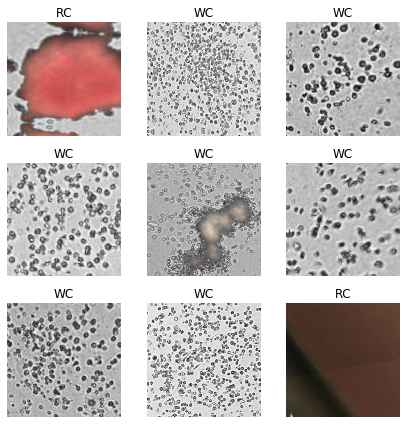

In [19]:
data.show_batch(rows=3, figsize=(6, 6))

In [20]:
print(data.classes)
len(data.classes), data.c

['RC', 'WC']


(2, 2)

## Training: resnet34

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [22]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [23]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.320864,0.021478,0.003586,00:16
1,0.064240,0.016029,0.004184,00:15
2,0.029641,0.016864,0.004782,00:15
3,0.014556,0.015893,0.004782,00:16


In [24]:
learn.save('stage-1')

## Results

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

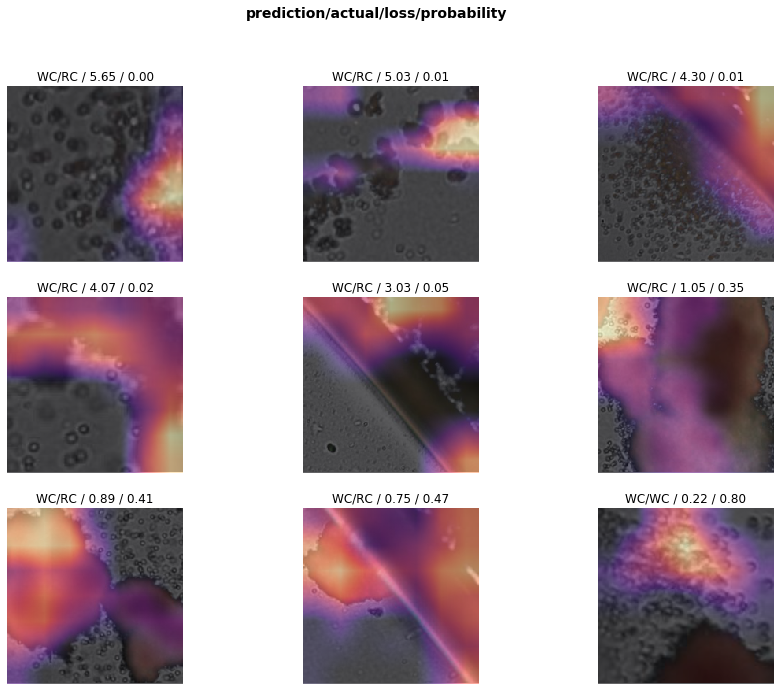

In [26]:
interp.plot_top_losses(9, figsize=(15,11))

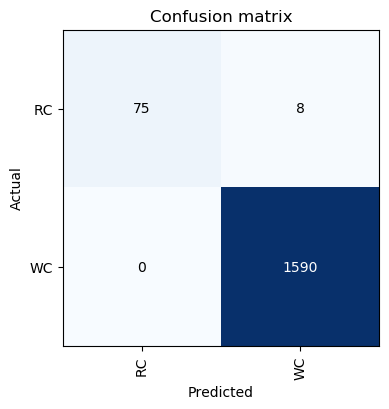

In [27]:
interp.plot_confusion_matrix(figsize=(4, 4), dpi=100)

## Let's build confusion matrix on test data

Previous confusion matrix also was built on the *"unseen"* `validation` dataset. Additional confusion matrix is just another check.

In [28]:
data_test = ImageDataBunch.from_folder(path, train="train", valid="test", ds_tfms=get_transforms(),
                                       size=224, bs=bs).normalize(imagenet_stats)

In [29]:
learn_test = cnn_learner(data_test, models.resnet34, metrics=error_rate)

In [30]:
learn_test.load('stage-1');

In [31]:
interp_test = ClassificationInterpretation.from_learner(learn_test)

losses_test,idxs_test = interp.top_losses()

len(data.valid_ds)==len(losses_test)==len(idxs_test)

True

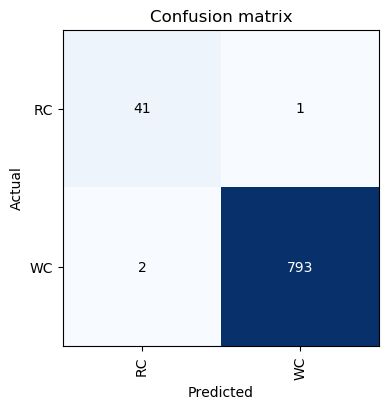

In [32]:
interp_test.plot_confusion_matrix(figsize=(4, 4), dpi=100)

## Unfreezing, fine-tuning, and learning rates

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


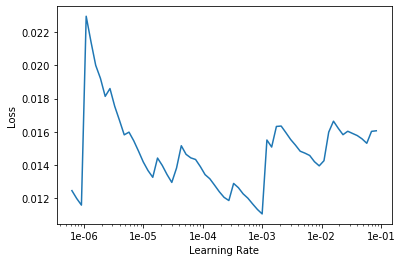

In [34]:
learn.recorder.plot()

In [35]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(2e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.009354,0.015205,0.004184,00:18
1,0.010132,0.011876,0.003586,00:17


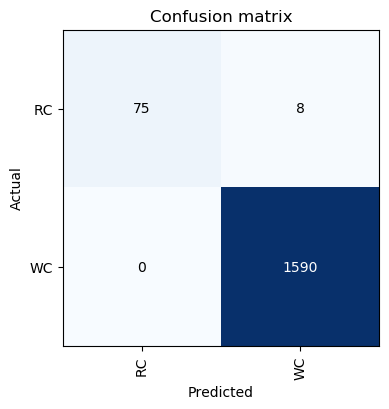

In [36]:
interp.plot_confusion_matrix(figsize=(4, 4), dpi=100)

In [37]:
learn.save('stage-2')